This is a minimal version of the [Notebook from Chapter 2](https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb) of [Natural Language Processing with Transformers, by Tunstall, von Werra and Wolf](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/).

The full version would not run on a P100 (e.g. via Kaggle) and so this is a cut down version.

# Load the dataset

This dataset is from ["CARER: Contextualized Affect Representations for Emotion Recognition"](http://dx.doi.org/10.18653/v1/D18-1404.)
From the paper:

> We construct a set of hashtags to collect a separate dataset of English tweets from the Twitter API.
> Specifically, we use the eight basic emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, and trust.
> The hashtags (339 total) serve as noisy labels, which allow annotation via distant supervision as in (Go et al., 2009).
> To ensure data quality, we follow the pre-processing steps proposed by (Abdul-Mageed and Ungar, 2017), and considered the hashtag appearing in the last position of a tweet as the ground truth.
> We split the data into training (90%) and testing (10%) datasets.

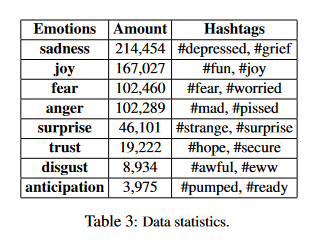

In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")

# Tokenize

In [2]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [3]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [4]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Set the tokenized dataset to output Pytorch tensors.

In [5]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

# Define performance metrics

In [6]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Fine Tuning Transformers

In [7]:
import torch
from transformers import AutoModelForSequenceClassification

num_labels = 6
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

A few changes to get this running in Kaggle:

* turned off pushing to Hub, so didn't need to login
* added report_to="none", to [turn off reporting to wandb](https://discuss.huggingface.co/t/how-to-turn-wandb-off-in-trainer/6237), otherwise training blocks prompting for an API key in Kaggle

In [8]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  report_to="none",
                                  log_level="error")

In [9]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

## Evaluate Finetuned Model

In [10]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [11]:
preds_output.metrics

# Error analysis

In [12]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [13]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [14]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [15]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Increase the column width displayed by Pandas so we can read the texts.

In [16]:
import pandas as pd
pd.options.display.max_colwidth = 1000

Many of these labels seem *curious*. This is because the mapping from hashtags to emotions isn't perfect. In particular the tags `#joy` and `#fun` seem to be used sarcastically.


In [17]:
df_test.sort_values("loss", ascending=False).head(10)

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [19]:
import numpy as np

labels = emotions["train"].features["label"].names

y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, emotions["validation"]["label"], labels)